# Sentiment Analysis

In [38]:
from __future__ import annotations

from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from sklearn.base import BaseEstimator

import re
import warnings
from functools import cache

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Memory
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from app.constants import CACHE_DIR, SENTIMENT140_PATH
from app.model import TextCleaner, TextLemmatizer

In [2]:
SEED = 42
MAX_FEATURES = 20000

In [3]:
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /home/tymec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tymec/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data

### Load the data

In [8]:
# Load the data
data = pd.read_csv(
    SENTIMENT140_PATH,
    encoding="ISO-8859-1",
    names=[
        "target",  # 0 = negative, 2 = neutral, 4 = positive
        "id",  # The id of the tweet
        "date",  # The date of the tweet
        "flag",  # The query, NO_QUERY if not present
        "user",  # The user that tweeted
        "text",  # The text of the tweet
    ],
)

# Ignore rows with neutral sentiment
data = data[data["target"] != 2]

# Map the sentiment values
data["sentiment"] = data["target"].map({0: "negative", 4: "positive"})

# Show the first few rows
data.head()

,target,id,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",negative


### Load the stopwords

In [22]:
stopwords_en = stopwords.words("english")

### Explore the data

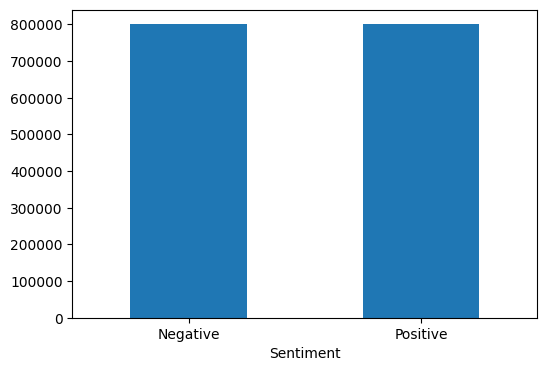

In [9]:
# Plot the distribution
_, ax = plt.subplots(figsize=(6, 4))
data["sentiment"].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(["Negative", "Positive"], rotation=0)
ax.set_xlabel("Sentiment")
ax.grid(False)
plt.show()

In [10]:
@cache
def extract_words(text: str) -> list[str]:
    return re.findall(r"(\b[^\s]+\b)", text.lower())

In [11]:
# Extract words and count them
words = data["text"].apply(extract_words).explode()
word_counts = words.value_counts().reset_index()
word_counts.columns = ["word", "count"]
word_counts.head()

,word,count
0,i,750749
1,to,564469
2,the,520036
3,a,377506
4,my,314024


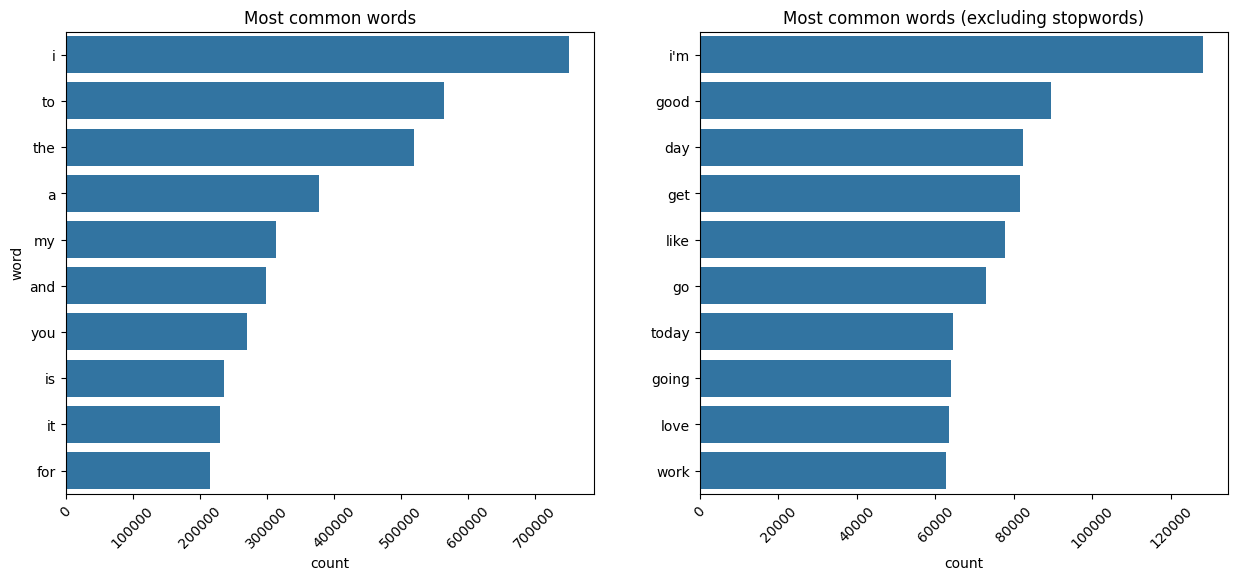

In [12]:
# Plot the most common words
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=word_counts.head(10), x="count", y="word", ax=ax1)
ax1.set_title("Most common words")
ax1.grid(False)
ax1.tick_params(axis="x", rotation=45)

ax2.set_title("Most common words (excluding stopwords)")
sns.barplot(
    data=word_counts[~word_counts["word"].isin(stopwords_en)].head(10),
    x="count",
    y="word",
    ax=ax2,
)
ax2.grid(False)
ax2.tick_params(axis="x", rotation=45)
ax2.set_ylabel("")

plt.show()

### Split the data

In [13]:
# Set the features and target
X, y = data["text"].tolist(), data["sentiment"].tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Model

### Preprocess and tokenize the data

In [23]:
# Create the preprocessing pipeline
preprocess_pipeline = Pipeline(
    [
        # Text preprocessing
        ("clean", TextCleaner()),
        ("lemma", TextLemmatizer()),
        # Preprocess (NOTE: Can be replaced with TfidfVectorizer, but left for clarity)
        ("vectorize", CountVectorizer(stop_words=stopwords_en, ngram_range=(1, 2), max_features=MAX_FEATURES)),
        ("tfidf", TfidfTransformer()),
    ],
    memory=Memory(CACHE_DIR, verbose=0),
    verbose=True,
)

In [24]:
# Fit the pipeline
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preprocess_pipeline.fit(X_train)

[Pipeline] ......... (step 3 of 4) Processing vectorize, total=  41.9s
[Pipeline] ............. (step 4 of 4) Processing tfidf, total=   0.0s


/home/tymec/university/projekt-psi/.venv/lib/python3.12/site-packages/joblib/memory.py:577: UserWarning: Persisting input arguments took 0.55s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=False)[0]


Pipeline(memory=Memory(location=.cache),
         steps=[('clean', TextCleaner()), ('lemma', TextLemmatizer()),
                ('vectorize',
                 CountVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer())],
         verbose=True)

In [25]:
# Transform the data
X_train_preprocessed = preprocess_pipeline.transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

### Pick the classifier

In [ ]:
def evaluate_model(clf: BaseEstimator) -> None:
    # Calculate the accuracy
    accuracy = clf.score(X_test_preprocessed, y_test)

    # Calculate the confusion matrix
    y_pred = clf.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    categories = ["Negative", "Positive"]
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_percentages = [f"{value:.2%}" for value in cm.flatten() / cm.sum()]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    _, ax = plt.subplots(figsize=(8, 6))
    ax.grid(False)
    ax.set_title(f"Accuracy: {accuracy:.2%}")
    sns.heatmap(
        cm,
        xticklabels=categories,
        yticklabels=categories,
        annot=labels,
        square=True,
        cbar=False,
        cmap="viridis",
        linewidths=0.5,
        fmt="",
        ax=ax,
    )
    plt.show()

In [ ]:
def random_search(clf: BaseEstimator, param_distributions: dict) -> tuple[BaseEstimator, dict]:
    # Create the search
    search = RandomizedSearchCV(
        clf,
        param_distributions,
        n_iter=10,
        scoring="accuracy",
        n_jobs=-1,
        cv=3,
        random_state=SEED,
        verbose=1,
    )

    # Fit the search
    search.fit(X_train_preprocessed, y_train)

    # Print the best parameters
    print(f"Best parameters: {search.best_params_}")

    return search.best_estimator_, search.best_params_

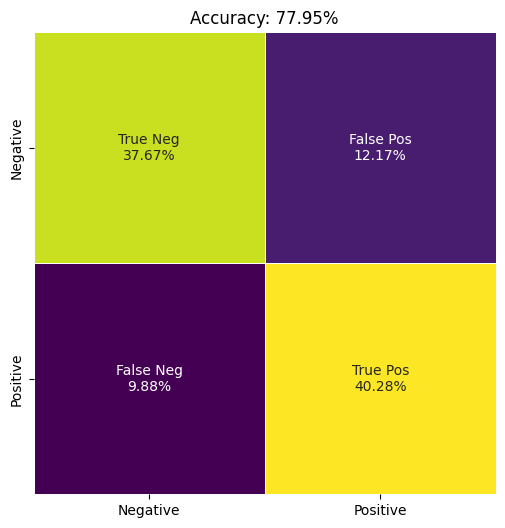

In [ ]:
# Logistic Regression
lr_clf = LogisticRegression(max_iter=1000, random_state=SEED)

# Find optimal hyperparameters
best_lr_clf, lr_params = random_search(
    lr_clf,
    {
        "C": np.logspace(-4, 4, 20),
        "solver": ["liblinear", "saga"],
        "penalty": ["l1", "l2"],
    },
)

# Evaluate the model
evaluate_model(best_lr_clf)

In [ ]:
# SVM
svm_clf = SVC(random_state=SEED)

# Find optimal hyperparameters
best_svm_clf, svm_params = random_search(
    svm_clf,
    {
        "C": np.logspace(-4, 4, 20),
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4],
    },
)

# Evaluate the model
evaluate_model(best_svm_clf)